#Introduction
<br>


This document presents the replication of the transfer learning method known as MaskTune, originally proposed by *Saeid Asgari Taghanaki, Aliasghar Khani, Fereshte Khani, Ali Gholami, Linh Tran, Ali Mahdavi-Amiri, Ghassan Hamarneh*.<br>
 MaskTune is a versatile approach applicable to various supervised tasks, designed to mitigate spurious correlations between specific features and target variables, often caused by data biases. This method compels the model to explore a broader range of features, reducing over-reliance on spurious correlations.
<br><br>
**What is MaskTune?** <br>

MaskTune is a method that can be applied as an auxiliary technique in conjunction with any supervised task. Its primary objective is to mitigate the impact of spurious correlations between certain features and target variables, frequently induced by biased data. MaskTune achieves this by encouraging the model to diversify its feature exploration.

<br>

**How does MaskTune work?**
<br>

MaskTune can be implemented with any Convolutional Neural Network (CNN) model and consists of the following steps:


1. The model is fully trained until it reaches a stationary performance regime.

2. A gradient-based method called GradCAM is employed to compute gradients of the model's output with respect to the last convolutional layer's output. This identifies the most significant features for the model. These features are then masked, compelling the model to investigate other features.

3. A single epoch of fine-tuning is performed on the model using the masked input.


<br><br>

**Document overview**

The document is structured into 3 main parts:

1. First part consisting of the implementation of the *Trainer* class , and importing of all useful libraries. For testing please execute all the cells of this part.

2. The second part involves applying MaskTune to a modified version of the MNIST10 dataset. In this section, we apply MaskTune to a modified version of the MNIST10 dataset. The MNIST10 dataset contains images of handwritten digits from 0 to 9. To introduce spurious correlations, we manipulate the training set by adding a small square (4x4 pixels) to 99% of the data in classes 0-4 and to 1% of the data in classes 5-9. The test set undergoes the opposite treatment. For this task, a simple CNN model with four CNN layers and two fully connected layers is utilized.

3. The final part tackles the "Background Challenge," a more complex and realistic classification task. The dataset is sourced from ImageNet, and we employ the ResNet18 model with pre-trained weights. To streamline the process, we fine-tune the model while freezing all CNN layer weights except the last one. The trainable layers include the last CNN layer and the fully connected layer.



**Results**
- In our experiments with the MNIST dataset, we observe notable improvements in average accuracy, both in the raw test set and the modified test set. Raw test set accuracy increases from 0.9097 to 0.9303, while modified test set accuracy rises from 0.9070 to 0.9251.


**Instruction for using this notebook**
- Execute all the cells of *Preprocessing* section.

*Then*:
- If you want to test MaskTune on MNIST dataset, execute also *Spurious MNIST classification* section.
- If you want to test MaskTune on Background challenge, firstly, choose a dataset between ImageNet and 3 its variants. Initialize *data_name* into one of ['in9l', 'mixed_rand', 'mixed_same', 'only_fg']. Then execute all cells in *Background challenge* section.


**References**
- MaskTune: Mitigating Spurious Correlations by Forcing to Explore. by *Saeid Asgari Taghanaki, Aliasghar Khani, Fereshte Khani, Ali Gholami, Linh Tran, Ali Mahdavi-Amiri, Ghassan Hamarneh*<br>
https://arxiv.org/abs/2210.00055
- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
by *Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra*<br>
https://arxiv.org/abs/1610.02391
- Noise or Signal: The Role of Image Backgrounds in Object Recognition
by *Kai Xiao, Logan Engstrom, Andrew Ilyas, Aleksander Madry* <br>
https://arxiv.org/abs/2006.09994
- Deep Residual Learning for Image Recognition
by *Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun*<br>
https://arxiv.org/abs/1512.03385



#1. Preprocessing

In [44]:
!pip install torchmetrics --quiet
!pip install pytorch-gradcam --quiet
!pip install grad-cam --quiet

In [45]:
from pytorch_grad_cam import XGradCAM

##1.1 Importing libraries

In [46]:
import torch

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import *
from torchmetrics.functional import accuracy
from torchmetrics import Accuracy
from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np
from google.colab import files
import glob
from PIL import Image
import cv2

import random

torch.manual_seed(12515)
from tqdm import tqdm
from time import time, ctime

from google.colab import files
import glob
from PIL import Image
import cv2

import os


##1.2 *Trainer* class

In [54]:
from IPython.core import inputtransformer2

class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        loss_function,
        optimizer,
        callbacks,
        num_channels,
        threshold,
        patience = None,
         ##Path where the best model will be saved
        ):

        ###Initialize
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        #self.scheduler = scheduler
        self.patience = patience
        self.callbacks = callbacks
        self.threshold = threshold
        self.num_channels = num_channels
        self.train_loss_list = []
        self.valid_loss_list = []

    def train(self,
              train_dataset_sp: Dataset,
              valid_dataset_sp: Dataset,
              test_dataset_sp: Dataset,
              second_testset = None,
              epochs:int=1, tuning:bool = False): # when tuning, all prints would be silenced
        ###The Trainer class will firstly train the model using the raw dataset to give a primitive model, then finetuning this model using the spurious model and and masktune tecnique.

        print('Training ...\n\n')
        train_loss = 0.0
        patience = 0
        task = 'binary' if self.model.num_classes == 2 else 'multiclass'
        n_cls =int(self.model.num_classes)

        train_acc_initial = Accuracy(task, num_classes = n_cls).to(self.device)
        train_acc_final = Accuracy(task, num_classes = n_cls).to(self.device)
        valid_acc_initial = Accuracy(task, num_classes = n_cls).to(self.device)
        valid_acc_final = Accuracy(task, num_classes = n_cls).to(self.device)
        test_acc_initial = Accuracy(task, num_classes = n_cls).to(self.device)
        test_acc_final = Accuracy(task, num_classes = n_cls).to(self.device)
        if second_testset:
          second_test_acc_initial = Accuracy(task, num_classes = n_cls).to(self.device)
          second_test_acc_final = Accuracy(task, num_classes = n_cls).to(self.device)

        ##First epoch, training with raw data without any spurious feature, to compute model initial, the following epochs will be used to finetune this primitive model, using spurious data, into the so called model final
        print('Initial traning with un-masked dataset, start time: ', ctime())
        train_acc = []
        valid_acc = []
        for epoch in range(epochs):
            if epoch > 5 and self.patience:
              if self.callbacks.early_stopping(input = self.valid_loss_list, patience = self.patience):
                if not tuning:
                  print('Training stopped for reaching stationary regime.')
                break
            self.model.train()
            # for each batch
            train_loss_total, train_acc_total, valid_loss_total, valid_acc_total = self.run_an_epoch(epoch, train_dataset_sp, valid_dataset_sp, train_acc_initial, valid_acc_initial)

            self.train_loss_list.append(train_loss_total)
            self.valid_loss_list.append(valid_loss_total)
            train_acc.append(train_acc_total.to('cpu'))
            valid_acc.append(valid_acc_total.to('cpu'))
        print('End traning for initial model...')
        print('Testing')
        test_loss_total, test_acc_total = self.evaluate(test_dataset_sp, test_acc_initial)

        if second_testset:
          test_loss_total_second, test_acc_total_second = self.evaluate(second_testset, second_test_acc_initial)
          print('Accuracy on raw testset: {:0.4f}'.format(test_acc_total_second))

        print('Accuracy on spurious testset: {:0.4f}'.format(test_acc_total))
        ################################################################################
        ##-----------------Mask------------------
        image_masked_tensor = torch.FloatTensor([])
        count = 0
        epoch_loss = 0
        plt.figure(figsize=(20, 6))

        train_acc_final.reset()
        for steps, batch in tqdm(enumerate(train_dataset_sp), disable=tuning):
            inputs = batch['image']
            heatmap_gn = XGradCAM(self.model, target_layers = [self.model.get_conv_out()], use_cuda = True if torch.cuda.is_available() else False)

            heatmap = heatmap_gn(inputs) ##heatmap has the dimension of (batch_size, height, width)
            threshold = self.find_threshold(heatmap) ## this function would return a np.ndarray of dim (batch_size,)

            heatmap = torch.FloatTensor(heatmap).to(self.device)
            threshold = torch.FloatTensor(threshold).to(self.device).unsqueeze(-1).unsqueeze(-1).expand_as(heatmap)

            boolean = torch.gt(threshold, heatmap).int()
            if self.num_channels == 3:
              boolean = boolean.unsqueeze(1).expand(inputs.size())

            ###Masking
            input_masked = inputs.clone()

            input_masked *= boolean



            ####Plotting for visualization
            if count < 6:
              count += 1
              plt.subplot(2, 6, count)
              if self.num_channels == 1:

                plt.imshow(inputs[count-1].to('cpu'), cmap = 'Greys')
                plt.imshow(heatmap[count-1].to('cpu'), cmap = 'Reds', alpha = 0.4)
                plt.colorbar()

                plt.subplot(2, 6, count+6)
                plt.imshow(input_masked[count-1].to('cpu'), cmap = 'Blues')

              if self.num_channels == 3:

                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                std_inv = [1.0/a for a in std]
                mean_inv = [-a/b for a,b in zip(mean, std)]
                normalize_inv = transforms.Normalize(mean = mean_inv, std = std_inv)
                image = normalize_inv(inputs[count-1]).to('cpu').permute(1,2,0)
                plt.imshow(image, interpolation = 'nearest')
                plt.imshow(heatmap[count-1].to('cpu'), cmap = 'Reds', alpha = 0.4)
                plt.colorbar()

                plt.subplot(2, 6, count+6)
                masked = nn.functional.relu(normalize_inv(input_masked[count-1]).to('cpu').permute(1,2,0))
                plt.imshow(masked, interpolation = 'nearest')



            #####Finetuning with masked data
            self.model.train()
            labels = batch['label']
            self.optimizer.zero_grad(set_to_none=True)
            logits = self.model(input_masked)
            logits = logits.view(-1, logits.shape[-1])
            labels = labels.view(-1)

            sample_loss = self.loss_function(logits, labels)
            sample_loss.backward()
            self.optimizer.step()

            train_acc_final.update(nn.Softmax(dim=-1)(logits), labels)
            epoch_loss += sample_loss.tolist()

        train_loss = epoch_loss/(steps+1.0)
        train_acc_total = train_acc_final.compute()
        valid_loss, valid_acc_total = self.evaluate(valid_dataset_sp, valid_acc_final)

        print('\n\nFinetuned model with masked data')
        print('\t\t train loss: {:0.4f} ---- train accuracy: {:0.4f}'.format(train_loss, train_acc_total))
        print('\t\t valid loss = {:0.4f} ---- valid accuracy: {:0.4f}'.format(valid_loss, valid_acc_total))
        test_loss_final, test_acc_final_total = self.evaluate(test_dataset_sp, test_acc_final)
        if second_testset:
          test_loss_total_second, test_acc_total_second = self.evaluate(second_testset, second_test_acc_final)
          print('\t\t test accuracy on raw dataset: {:0.4f}'.format(test_acc_total_second))
        print('\t\t test accuracy: {:0.4f}'.format(test_acc_final_total))
        ##-----------------Tune------------------


        print('\n\n\n')
        print('End of training.  ', ctime() )
        print('\n\n\n\n\n')
        if not tuning:
          self.callbacks.plotting(self.train_loss_list, self.valid_loss_list, train_acc, valid_acc)
        avg_epoch_loss = train_loss / (epoch+1)

        return avg_epoch_loss


    def evaluate(self, data, acc):
        valid_loss = 0.0
        # set dropout to 0!! Needed when we are in inference mode.
        self.model.eval()
        acc.reset()
        with torch.no_grad():
            for sample in data:
                inputs = sample['image']
                labels = sample['label']
                logits = self.model(inputs)
                logits = logits.view(-1, logits.shape[-1])
                preds = nn.Softmax(dim=-1)(logits)
                labels = labels.view(-1)
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()
                acc.update(preds, labels)

            total_acc = acc.compute()
        return valid_loss / len(data), total_acc

    def run_an_epoch(self, epoch, train_data, valid_data, train_acc, valid_acc, tuning=False):
        train_acc.reset()
        epoch_loss=0
        for step, sample in tqdm(enumerate(train_data), disable=tuning):
            inputs = sample['image']
            labels = sample['label']

            self.optimizer.zero_grad(set_to_none=True)
            logits = self.model(inputs)
            logits = logits.view(-1, logits.shape[-1])
            labels = labels.view(-1)

            sample_loss = self.loss_function(logits, labels)
            sample_loss.backward()
            self.optimizer.step()

            train_acc.update(nn.Softmax(dim=-1)(logits), labels)
            epoch_loss += sample_loss.tolist()


        train_loss = epoch_loss/(step+1.0)
        train_acc_total = train_acc.compute()
        valid_loss, valid_acc_total = self.evaluate(valid_data, valid_acc)
        print('\n\nTraining epoch: {}'.format(epoch))
        print('\t train loss: {:0.4f} ---- train accuracy: {:0.4f}'.format(train_loss, train_acc_total))
        print('\t valid loss = {:0.4f} ---- valid accuracy: {:0.4f}'.format(valid_loss, valid_acc_total))

        return train_loss, train_acc_total, valid_loss, valid_acc_total


    def find_threshold(self, heatmap):
      ##This function find compute the mean and the std of heatmap of each image,
      ##then stabilize the threshold to be applied to masking function accordint to mean and std

      mask_mean_value = np.nanmean(heatmap, axis = (-2,-1), where=(heatmap>-0.1))
      mask_std_value = np.nanstd(heatmap, axis = (-2,-1), where = (heatmap>-0.1))

      mask_threshold_value = mask_mean_value + 1.2 * mask_std_value

      return mask_threshold_value



    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            predictions = torch.argmax(logits,-1)

        return logits, predictions



In [47]:
print(ctime())

Fri Sep  1 14:20:11 2023


In [53]:
class callbacks():
  '''
  this class contains the ausiliary functions for trainer, t
  '''
  def __init__(self,
               num_classes,
               PATH,
               patience=5,
               ):
    self.patience = patience
    self.path = PATH
    if num_classes == 2:
      self.test_acc = Accuracy('binary')
      self.valid_acc = Accuracy('binary')
    else:
      self.test_acc = Accuracy('multiclass', num_classes=int(num_classes))
      self.valid_acc = Accuracy('multiclass', num_classes=int(num_classes))
  def early_stopping(input, patience):
    if input[-1] > input[-1-patience]:##Input should the loss of dev set, if return true, the function would stop the training.
      return True
    else:
      return False

  def plot_heatmap(image, heatmap):
    plt.figure(figsize=(10, 10))
    plt.title('Grad CAM result')
    plt.imshow(image)
    plt.imshow(heatmap)
    plt.show()


  def plotting(train_loss, dev_loss, train_acc, dev_acc):
    epochs = range(len(train_loss))
    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label= 'Training loss', color = 'salmon')
    plt.plot(epochs, dev_loss, label = 'Validation loss', color = 'lightseagreen')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('Cross-Entropy loss')
    #plt.savefig('content/plots/Loss_Iden.pdf')


    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label = 'Accuracy on train set', color = 'salmon')
    plt.plot(epochs, dev_acc, label = 'Accuracy on validation set', color = 'lightseagreen')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.show()
    return None

  def save_the_best(model, PATH):
    torch.save(model.state_dict(), self.path + '' +'best_model.pth')
    pass

#2. Spurious MNIST classification

##2.1 Importing dataset(s)

In [48]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train = False, download = True, transform = ToTensor())
print(len(mnist_trainset))
print(len(mnist_testset))

60000
10000


In [49]:
print(mnist_trainset.__len__)

<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()>


##2.2 Raw dataset visualization

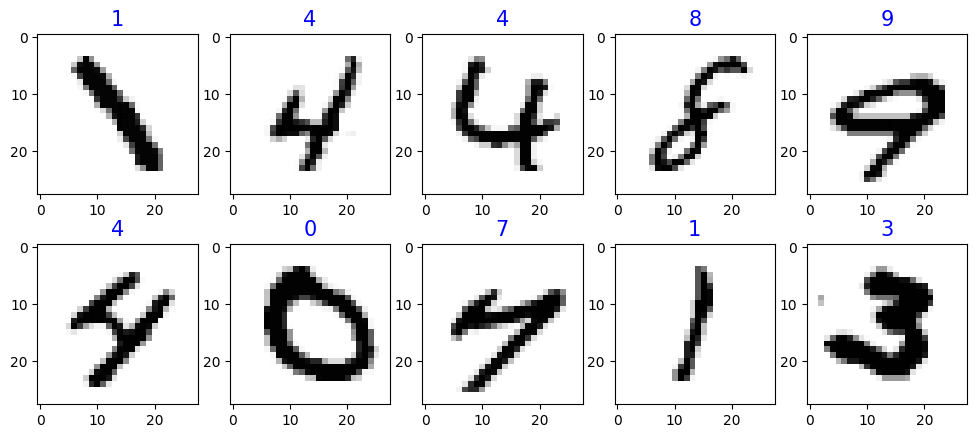

In [50]:
plt.figure(figsize=(12,5))
for i in range(10):
  plt.subplot(2,5,i+1)
  image = mnist_trainset.data[i*123+134]
  label = mnist_trainset.targets[i*123+134]
  image[0:5, 0:5] = 0.5
  plt.imshow(image, cmap='Greys')
  plt.title(label.item(),fontsize=15, color = 'blue')

##2.3 Creating spurious MNIST dataset

In [51]:
##In the original code data with spuriouses are called biased MNIST
class biasedMNIST(Dataset):
  '''
  The aim of this class is to create the biased MNIST dataset, the data will be split into 2 classes, the class 0 will contain all the data with label within (0-4)
  and class 1 will cover the remanining. 99% of class 0 will have a square of size 4x4 on the top-left corner of the image,
  while the same square will appear only in 1% of the images in class 1.
  '''

  def __init__(self,
               batch_size):
    super().__init__()

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data = self.load_data(train=True)
    self.data_sp = self.create_spurious_data(data, 'train')
    test_data = self.load_data(train=False)

    self.testset_raw = self.raw_data(test_data)
    self.testset = self.create_spurious_data(test_data, 'test')
    self.trainset, self.validset = random_split(self.data_sp, [0.8, 0.2])
  def load_data(self, train:bool):

    return datasets.MNIST(root='./data', train=train, download=True, transform=ToTensor())

  def raw_data(self, data):

    output = []
    for sample in data:
      label = sample[1]
      image = sample[0]
      output.append({'image' : torch.FloatTensor(image.squeeze(0)).to(self.device),
                     'label' : torch.LongTensor([label]).to(self.device)})

    return output

  def create_spurious_data(self, data, set_type : str):
    '''
    args:
      data: input data should MNIST class
      set_type : 'train' for training set, 'test' for testing set.
    output:
      if 'train':
        a spurious feature (a 4x4 square) will be present in 99 % of data in class 0 (label within 0 and 4) and 1% of data in class 1(label within 4 and 9).
      if 'test':
        all data belonging to class 0 would remain the same, but all data belonging to class 1 would have the spurious feature.
    '''
    output = []

    if set_type == 'train':
      for sample in data:
        label = sample[1]
        rd = random.random()
        image_cp = sample[0].clone()

        if int(label)<5:
          cls = 0
          if rd < 0.99:
            image_cp[:, :10, :10] = 0.5
        else:
          cls=1
          if rd >= 0.99:
            image_cp[:, :10, :10] = 0.5

        output.append({'image' : torch.FloatTensor(image_cp.squeeze(0)).to(self.device),
                      'label' : torch.LongTensor([label]).to(self.device),
                      'class' : torch.LongTensor([cls]).to(self.device)})
    elif set_type == 'test':
      for sample in data:
        label = sample[1]
        image_cp = sample[0].clone()

        if label > 5:
          image_cp[:5, :5] = 0.5
          cls = 1
        else:
          cls = 0
        output.append({'image' : torch.FloatTensor(image_cp.squeeze(0)).to(self.device),
                       'label' : torch.LongTensor([label]).to(self.device),
                       'class' : torch.LongTensor([cls]).to(self.device)})
    else:
      raise Exeption("the set type must be train or test!")
    return output





In [52]:
data4train = biasedMNIST(40)

##2.4 Simple CNN model

In [55]:
###Code taken from authors' github, https://github.com/aliasgharkhani/Masktune/blob/master/src/models/simple_cnn.py
class simpleCNN(nn.Module):
    def __init__(self, num_classes, num_channels=1):
        super().__init__()
        self.num_classes = num_classes
        self.num_channels = num_channels

        self.backbone = nn.Sequential(
            nn.Conv2d(num_channels, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2,2),(2,2)),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def get_conv_out(self):
      return self.backbone[-3]

    def forward(self, input):
        if self.num_channels == 1:
          x = torch.unsqueeze(input, -1).permute(0,3,1,2)
        else:
          x = input
        features = self.backbone(x)
        logits = self.linear(features)
        return logits

##2.5 Training

In [56]:
loss = CrossEntropyLoss()
callbakcs = callbacks(num_classes = 10, PATH ='dw')
BiasedMNIST_scnn = simpleCNN(num_classes = 10).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.SGD(BiasedMNIST_scnn.parameters(), lr = 0.001)


In [57]:
trainer_scnn = Trainer(BiasedMNIST_scnn, loss, optimizer, callbacks = callbacks, num_channels = 1,threshold = 0.6, patience = 3)

In [58]:
trainloader = DataLoader(data4train.trainset, 40, shuffle=True)
validloader = DataLoader(data4train.validset, 40, shuffle=False)
testloader = DataLoader(data4train.testset, 40, shuffle=False)
raw_testloader = DataLoader(data4train.testset_raw, 40, shuffle = False)

Training ...


Initial traning with un-masked dataset, start time:  Fri Sep  1 14:20:34 2023


1200it [00:05, 227.03it/s]




Training epoch: 0
	 train loss: 0.8466 ---- train accuracy: 0.8505
	 valid loss = 0.3313 ---- valid accuracy: 0.9567


1200it [00:05, 229.36it/s]




Training epoch: 1
	 train loss: 0.2585 ---- train accuracy: 0.9622
	 valid loss = 0.1715 ---- valid accuracy: 0.9718


1200it [00:05, 237.38it/s]




Training epoch: 2
	 train loss: 0.1671 ---- train accuracy: 0.9719
	 valid loss = 0.1229 ---- valid accuracy: 0.9775


1200it [00:04, 244.14it/s]




Training epoch: 3
	 train loss: 0.1290 ---- train accuracy: 0.9761
	 valid loss = 0.0986 ---- valid accuracy: 0.9808


1200it [00:04, 244.60it/s]




Training epoch: 4
	 train loss: 0.1070 ---- train accuracy: 0.9791
	 valid loss = 0.0830 ---- valid accuracy: 0.9837


1200it [00:04, 245.82it/s]




Training epoch: 5
	 train loss: 0.0927 ---- train accuracy: 0.9807
	 valid loss = 0.0738 ---- valid accuracy: 0.9844


1200it [00:04, 243.41it/s]




Training epoch: 6
	 train loss: 0.0828 ---- train accuracy: 0.9832
	 valid loss = 0.0652 ---- valid accuracy: 0.9862


1200it [00:04, 246.20it/s]




Training epoch: 7
	 train loss: 0.0748 ---- train accuracy: 0.9841
	 valid loss = 0.0593 ---- valid accuracy: 0.9876


1200it [00:04, 247.63it/s]




Training epoch: 8
	 train loss: 0.0691 ---- train accuracy: 0.9844
	 valid loss = 0.0560 ---- valid accuracy: 0.9878


1200it [00:04, 244.46it/s]




Training epoch: 9
	 train loss: 0.0633 ---- train accuracy: 0.9867
	 valid loss = 0.0524 ---- valid accuracy: 0.9883
End traning for initial model...
Testing
Accuracy on raw testset: 0.9097
Accuracy on spurious testset: 0.9070


1200it [00:18, 66.25it/s]




Finetuned model with masked data
		 train loss: 0.1501 ---- train accuracy: 0.9590
		 valid loss = 0.0581 ---- valid accuracy: 0.9858
		 test accuracy on raw dataset: 0.9303
		 test accuracy: 0.9251




End of training.   Fri Sep  1 14:21:50 2023








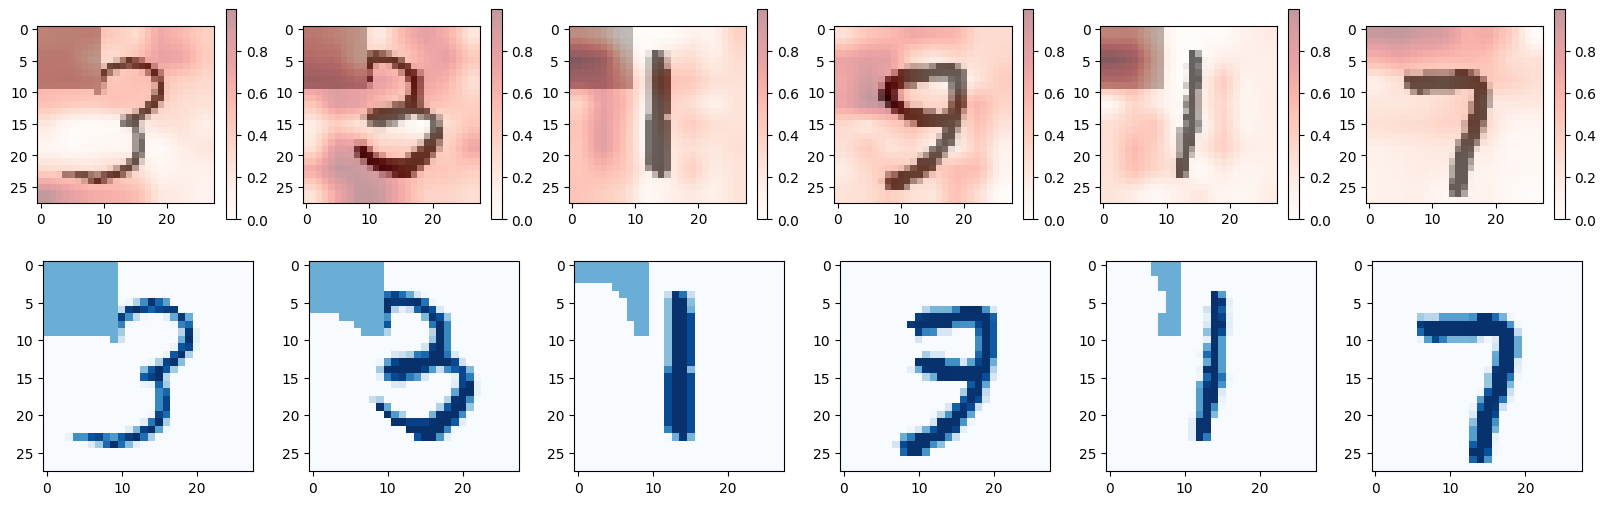

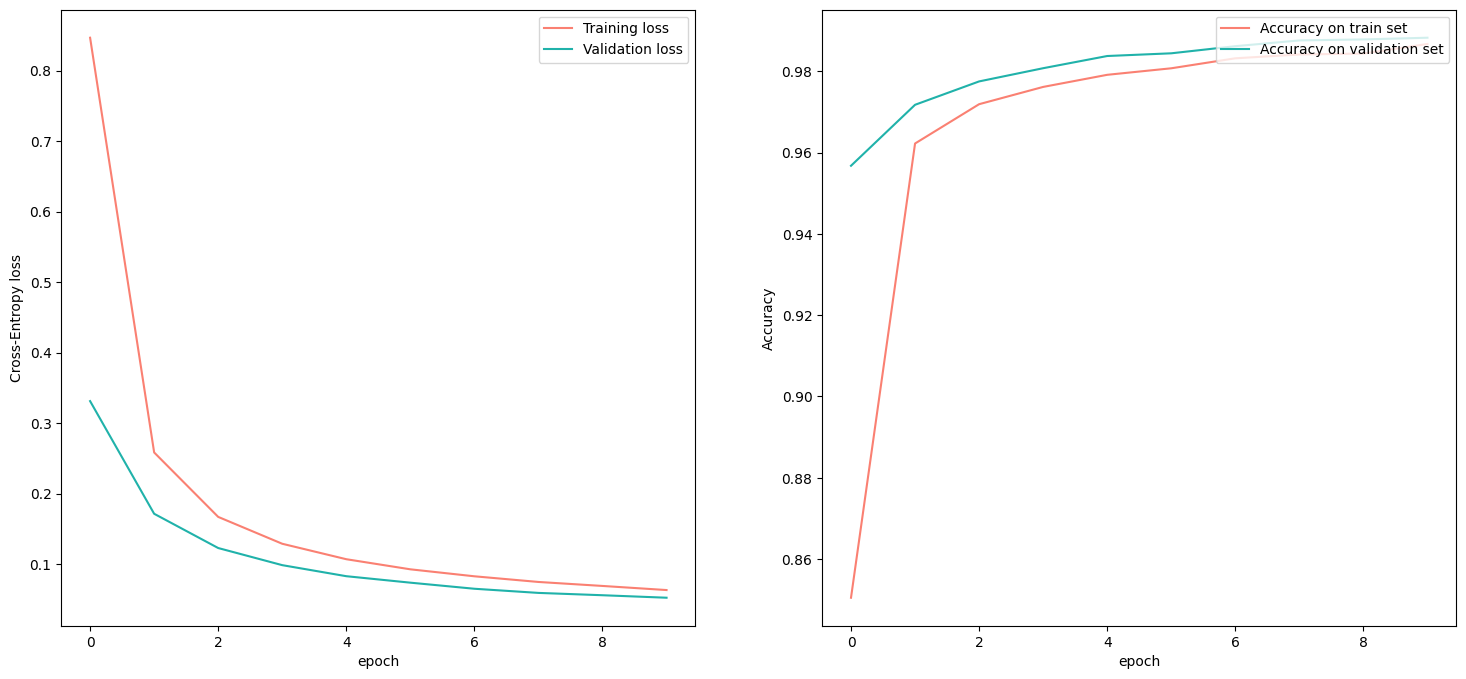

0.015014660989710441

In [59]:
trainer_scnn.train(trainloader, validloader, testloader, raw_testloader, epochs = 10)

#3. Background challenge

##3.1 Importing data from dropbox

In [60]:
!mkdir background_dataset

mkdir: cannot create directory ‘background_dataset’: File exists


In [61]:
#!wget https://www.dropbox.com/s/8w29bg9niya19rn/in9l.tar.gz?dl=0 &> /dev/null
!wget https://www.dropbox.com/s/cto15ceadgraur2/mixed_rand.tar.gz?dl=0 &> /dev/null
!wget https://www.dropbox.com/s/f2525w5aqq67kk0/mixed_same.tar.gz?dl=0 &> /dev/null
!wget https://www.dropbox.com/s/alrf3jo8yyxzyrn/only_fg.tar.gz?dl=0 &> /dev/null

In [62]:
!tar -xzvf /content/mixed_rand.tar.gz?dl=0  -C /content/background_dataset &> /dev/null
!tar -xzvf /content/mixed_same.tar.gz?dl=0  -C /content/background_dataset &> /dev/null
!tar -xzvf /content/only_fg.tar.gz?dl=0  -C /content/background_dataset &> /dev/null
#!tar -xzvf /content/in9l.tar.gz?dl=0  -C /content/background_dataset &> /dev/null


## 3.2 ResNet

In [63]:
##A pretrained ResNet is loaded and the first 3 layers are freezed for reducing the training time

class ResNet18(nn.Module):
  def __init__(self, num_classes):
    super(ResNet18, self).__init__()
    self.num_classes = num_classes
    self.resnet = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
    self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, num_classes)

    self.freeze_param()

  def freeze_param(self):
    for param in self.resnet.layer1.parameters():
      param.requires_grad=False

    for param in self.resnet.layer2.parameters():
      param.requires_grad=False

    for param in self.resnet.layer3.parameters():
      param.requires_grad=False

    for param in self.resnet.layer4[0].parameters():
      param.requires_grad=False

  def get_conv_out(self):
    return self.resnet.layer4[-1]

  def forward(self, input):
    output = self.resnet(input)
    return output


##3.3 streaming dataset class

A streaming dataset is created because the available GPU memory is insufficient for storing all the data from the source. This dataset compiles a list of all image file names, and when it is used, it extracts the images one by one based on the file names.

In [64]:
import glob
from PIL import Image
import cv2
from torchvision import transforms
import os
from tqdm import tqdm

class BG_Dataset_stream(Dataset):
  '''
  data_name: str, choose between ['in9l', 'mixed_rand', 'mixed_same', 'only_fg']
  partition: str, choose between ['train', 'val', 'test']
  '''
  def __init__(self, data_name, partition):
    self.device = 'cuda' if torch.cuda.is_available else 'cpu'
    self.classes = {'dog':0, 'bird': 1, 'wheeled_vehicle' : 2, 'reptile' : 3, 'carnivore' : 4, 'insect' : 5, 'musical_instrument' : 6, 'primate' : 7, 'fish' :8 }
    self.idx2class = {v:k for k,v in self.classes.items()}
    self.partition = partition

    if data_name == 'in9l':
      self.data = self.load_data('/content/background_dataset/in9l')
    elif data_name == 'mixed_rand':
      self.data = self.load_data('/content/background_dataset/mixed_rand')
    elif data_name == 'mixed_same':
      self.data = self.load_data('/content/background_dataset/mixed_same')
    elif data_name == 'only_fg':
      self.data = self.load_data('/content/background_dataset/only_fg')
    else:
      raise Exception('the data name must be choosen between [in9l, mixed_rand, mixed_same, only_fg]')

    print('Total num samples: ', self.num_samples)


  def load_data(self, dir_path): ##partirion can be choosen between ['train', 'val', 'test']
    if self.partition in ['train', 'val']:
      sub_dir_name = '/train/'
      class_names = os.listdir(dir_path + '/train')
    if self.partition == 'test':
      sub_dir_name = '/val/'
      class_names = os.listdir(dir_path + '/val')
    data = []
    print('Importing data...')
    for class_name in tqdm(class_names):
      class_dir = dir_path + sub_dir_name + class_name
      class_files = glob.glob(class_dir + '/*.JPEG')

      label_str = class_name.replace(' ', '_')[3:]
      label = int(self.classes[label_str])

      label = torch.LongTensor([label]).to(self.device)
      for image_file in class_files:
        data.append((image_file,
                    label))


    if self.partition in ['train', 'val']:
      train, val = random_split(data, [0.8, 0.2])
      if self.partition == 'train':
        self.num_samples = len(train)
        return train
      else:
        self.num_samples = len(val)
        return val
    elif self.partition == 'test':
      self.num_samples = len(data)
      return data
    else:
      raise Exception('Something wrong in loading data')



  def image2data(self, image_path):

    size =  (224, 224)
    transform = transforms.Compose([
        transforms.Resize(size),
        #transforms.Greyscale()
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    with Image.open(image_path) as img:
      image_tensor = torch.FloatTensor(transform(img)).to(self.device)

    return image_tensor
  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx):
    image_file, label = self.data[idx]

    image = self.image2data(image_file)
    return {'image': image,
            'label' : label}



In [65]:
data_name = 'mixed_rand'
BG_data_train = BG_Dataset_stream(data_name, 'train')
BG_data_val = BG_Dataset_stream(data_name, 'val')
BG_data_test = BG_Dataset_stream(data_name, 'test')

Importing data...


100%|██████████| 9/9 [00:00<00:00, 78.22it/s]


Total num samples:  36324
Importing data...


100%|██████████| 9/9 [00:00<00:00, 20.46it/s]


Total num samples:  9081
Importing data...


100%|██████████| 9/9 [00:00<00:00, 649.63it/s]

Total num samples:  4185


##3.4 Trainning

In [66]:
loss = CrossEntropyLoss()
callbakcs = callbacks(num_classes = 9, PATH ='dw')
ResNet_BG = ResNet18(num_classes = 9).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_BG = torch.optim.SGD(ResNet_BG.parameters(), lr = 0.1)


In [67]:
trainer_BG = Trainer(ResNet_BG, loss, optimizer_BG, callbacks = callbacks, num_channels = 3,threshold = 0.8, patience = 4)

In [68]:
train_loader = DataLoader(BG_data_train, batch_size = 128, shuffle=True)
val_loader = DataLoader(BG_data_val, batch_size = 128, shuffle=False)
test_loader = DataLoader(BG_data_test, batch_size = 128, shuffle=False)

Training ...


Initial traning with un-masked dataset, start time:  Fri Sep  1 14:25:29 2023


284it [01:42,  2.76it/s]




Training epoch: 0
	 train loss: 0.8702 ---- train accuracy: 0.7428
	 valid loss = 0.6207 ---- valid accuracy: 0.7961


284it [01:43,  2.75it/s]




Training epoch: 1
	 train loss: 0.4894 ---- train accuracy: 0.8335
	 valid loss = 0.5996 ---- valid accuracy: 0.7973


284it [01:43,  2.75it/s]




Training epoch: 2
	 train loss: 0.3831 ---- train accuracy: 0.8703
	 valid loss = 0.3732 ---- valid accuracy: 0.8792


284it [01:41,  2.80it/s]




Training epoch: 3
	 train loss: 0.2848 ---- train accuracy: 0.9024
	 valid loss = 0.3643 ---- valid accuracy: 0.8810


284it [01:42,  2.77it/s]




Training epoch: 4
	 train loss: 0.1939 ---- train accuracy: 0.9367
	 valid loss = 0.2943 ---- valid accuracy: 0.9098


284it [01:42,  2.77it/s]




Training epoch: 5
	 train loss: 0.1247 ---- train accuracy: 0.9602
	 valid loss = 0.3249 ---- valid accuracy: 0.9054


284it [01:42,  2.77it/s]




Training epoch: 6
	 train loss: 0.0708 ---- train accuracy: 0.9806
	 valid loss = 0.2066 ---- valid accuracy: 0.9500


284it [01:41,  2.79it/s]




Training epoch: 7
	 train loss: 0.0386 ---- train accuracy: 0.9914
	 valid loss = 0.1870 ---- valid accuracy: 0.9561


284it [01:42,  2.76it/s]




Training epoch: 8
	 train loss: 0.0185 ---- train accuracy: 0.9972
	 valid loss = 0.1691 ---- valid accuracy: 0.9632


284it [01:43,  2.75it/s]




Training epoch: 9
	 train loss: 0.0103 ---- train accuracy: 0.9991
	 valid loss = 0.1788 ---- valid accuracy: 0.9637


284it [01:42,  2.77it/s]




Training epoch: 10
	 train loss: 0.0065 ---- train accuracy: 0.9996
	 valid loss = 0.1594 ---- valid accuracy: 0.9654


284it [01:42,  2.76it/s]




Training epoch: 11
	 train loss: 0.0040 ---- train accuracy: 1.0000
	 valid loss = 0.1608 ---- valid accuracy: 0.9666


284it [01:41,  2.81it/s]




Training epoch: 12
	 train loss: 0.0038 ---- train accuracy: 0.9998
	 valid loss = 0.1650 ---- valid accuracy: 0.9666


284it [01:40,  2.82it/s]




Training epoch: 13
	 train loss: 0.0027 ---- train accuracy: 1.0000
	 valid loss = 0.1665 ---- valid accuracy: 0.9661


284it [01:40,  2.83it/s]




Training epoch: 14
	 train loss: 0.0022 ---- train accuracy: 0.9999
	 valid loss = 0.1675 ---- valid accuracy: 0.9660
Training stopped for reaching stationary regime.
End traning for initial model...
Testing
Accuracy on spurious testset: 0.8275


284it [02:35,  1.82it/s]




Finetuned model with masked data
		 train loss: 1.9680 ---- train accuracy: 0.4447
		 valid loss = 0.6625 ---- valid accuracy: 0.7794
		 test accuracy: 0.7097




End of training.   Fri Sep  1 15:00:13 2023








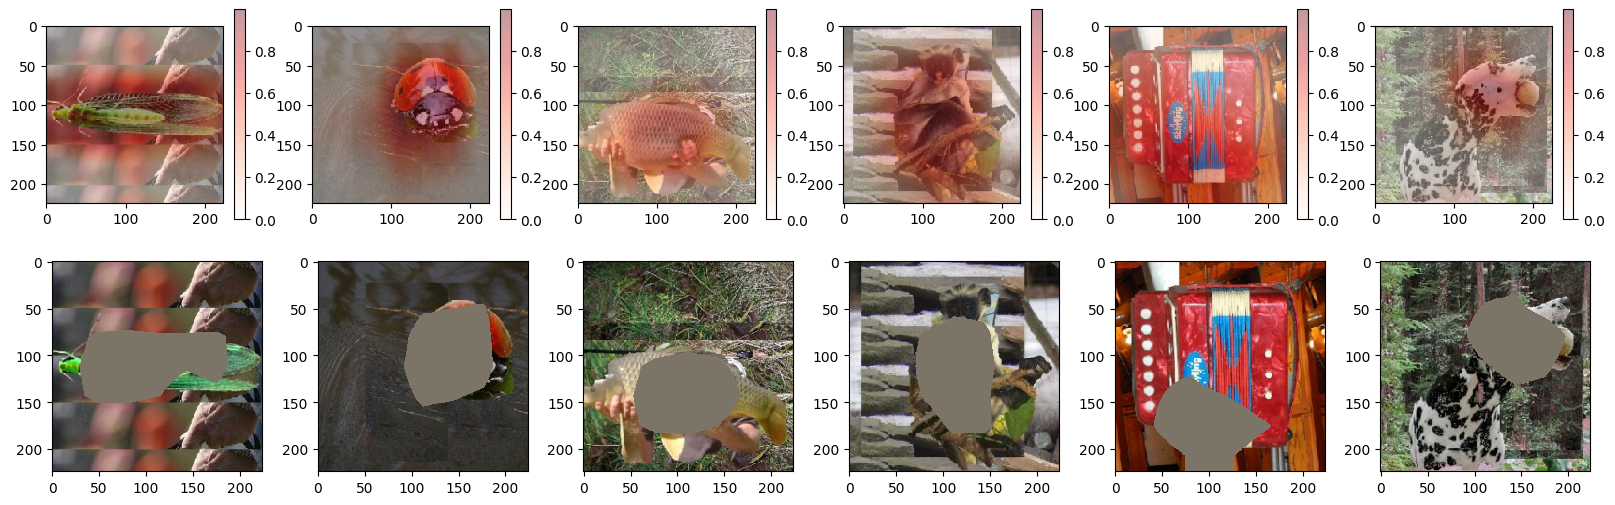

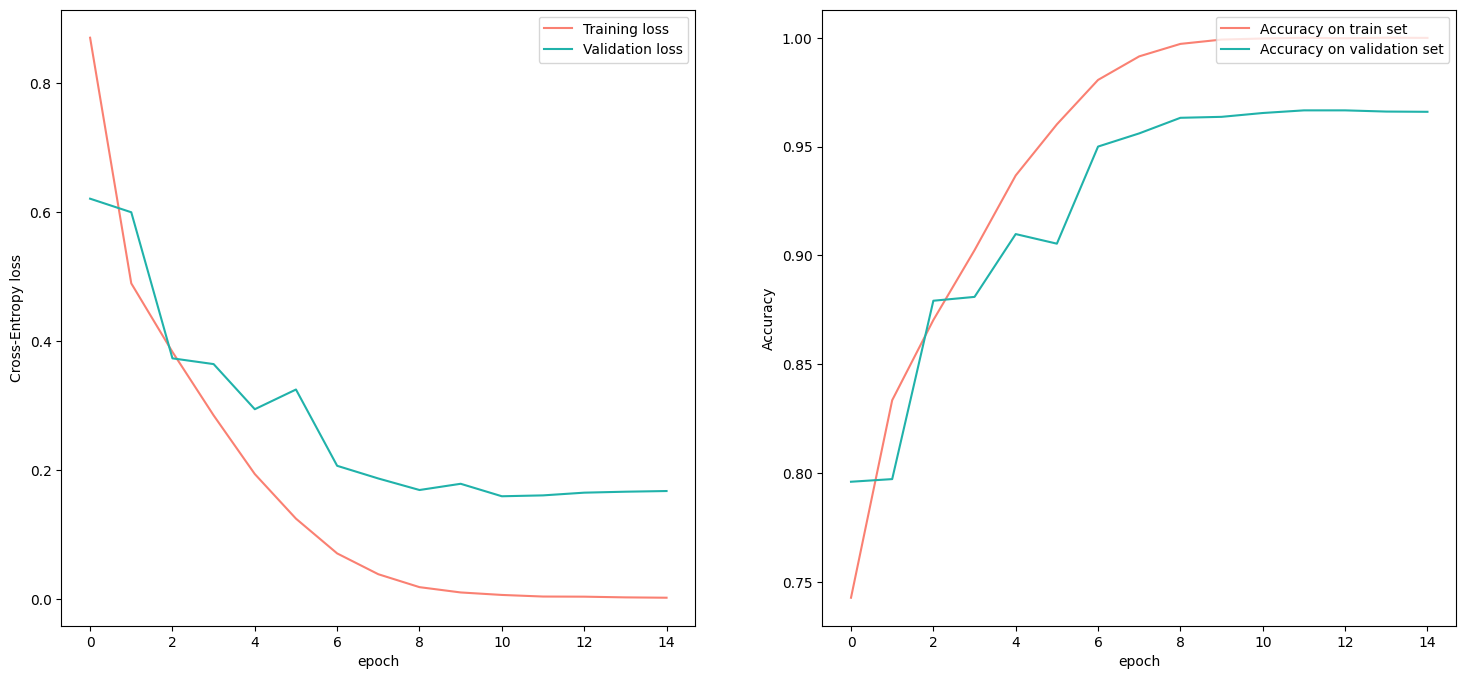

0.12300237527930401

In [69]:
trainer_BG.train(train_loader, val_loader, test_loader, epochs = 20)